# M2 TIDE : Application des connaissances

In [ ]:
# Import des packages
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import scipy.stats as st
import os
import sys

sys.path.insert(0, str(Path(os.getcwd()).resolve().parent.parent))
from src.utils.tools import (
    rename_field_categories,
    distrib_for_cat_by_target,
    distrib_for_cont_by_target,
    boxplot_by_target,
    plot_generic,
    cramers_v_between_all,
    cramers_v_with_target,
    graph_correlations,
    extract_corr_pairs,
)

#### Objectif : prédire si le client va rembourser le crédit qu'il souhaite souscrire

# 0. Vérifier les prérequis (cf rubrique d'installation du [README.md](../README.md))


# 1. Import des données

<div class="alert alert-block alert-warning">
<b> Question 1:</b> Importez le fichier csv "credit_scoring.csv" dans un dataframe nommé "df". Puis vérifiez que l'import
s'est bien déroulé.
</div>

In [ ]:
path = Path("../../data/raw/credit_scoring.csv").resolve() # chemin vers fichier csv
df = pd.read_csv(path,sep='|')

In [56]:
df.Cible.value_counts()
# df['Cible'].value_counts()

Cible
0    700
1    300
Name: count, dtype: int64

In [57]:
# Top5
df.head(5)

,Cible,Comptes,Duree_credit,Historique_credit,Objet_credit,Montant_credit,Epargne,Anciennete_emploi,Taux_effort,Situation_familiale,...,Anciennete_domicile,Biens,Age,Autres_credits,Statut_domicile,Nb_credits,Type_emploi,Nb_pers_charge,Telephone,Etranger
0,0,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,0,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,0,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,0,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,0,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


<div class="alert alert-block alert-warning">
<b> Question 2 :</b> Combien de lignes et champs mon dataframe "df" contient-il ?
</div>

# 2. Compréhension des données

### 2.1 Métadonnées 

<div class="alert alert-block alert-warning">
<b> Question 3:</b> Affichez le type de chaque champ de "df". Quel constat pouvez-vous faire ?
</div>

<div class="alert alert-block alert-info">
<b>📝Note :</b> Ne pas confondre <b>type de stockage</b> et <b>type de variable</b>. En effet, on constate que nos variables catégorielles sont stockées en int.
</div>

### 2.2 Remplacement des modalités (bonus)

Afin de gagner en lisibilité, nous allons labelliser les modalités pour nos variables catégorielles

In [63]:
dict_labels = {
    "Comptes": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": ['< 0 €', '[ 0 € ; 200 € [', '> 200 €', 'Sans']
    },
    "Historique_credit": {
        "init_values": [-1, 0, 1, 2, 3, 4],
        "new_values": [
            'Impayés passés',
            'Impayé en cours (autre banque)',
            'Jamais aucun crédit',
            'Crédits en cours sans retard',
            'Crédits en cours avec retard'
        ]
    },
    "Objet_credit": {
        "init_values": [-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
        "new_values": [
            'Voiture neuve',
            "Voiture d'occasion",
            'Mobilier / Equipement',
            'Radio / Télévision',
            'Appareils ménagers',
            'Travaux',
            'Etude',
            'Vacances',
            'Formation',
            'Business',
            'Autres'
        ]
    },
    "Epargne": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            '< 100 €',
            '[ 100 € ; 500 € [',
            '[ 500 € ; 1_000 € [',
            '> 1000 €',
            'Inconnu / Pas de compte'
        ]
    },
    "Anciennete_emploi": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            'sans emploi',
            '< 1 an',
            '[ 1 an ; 4 ans [',
            '[ 4 ans ; 7 ans [',
            '> 7 ans'
        ]
    },
    "Situation_familiale": {
        "init_values": [0, 1, 2, 3, 4, 5],
        "new_values": [
            'H: divorcé/séparé',
            'F: divorcée / séparée',
            'H: célibataire',
            'H: marié / veuf',
            'F: célibataire'
        ]
    },
    "Garanties": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Pas de garantie', 'Co-emprunteur', 'Garant']
    },
    "Biens": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": ['Immobilier', 'Assurance-vie', 'Voiture ou autre', 'Aucun bien connu']
    },
    "Autres_credits": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Banque', 'Etablissement de crédit', 'Aucun']
    },
    "Statut_domicile": {
        "init_values": [0, 1, 2, 3],
        "new_values": ['Locataire', 'Propriétaire', 'Hébergement gratuit']
    },
    "Type_emploi": {
        "init_values": [0, 1, 2, 3, 4],
        "new_values": [
            'Chômeur / Non-qualifié - Non-résident',
            'Non-qualifié - résident',
            'Employé qualifié / Fonctionnaire',
            'Cadre / Indépendant / Employé hautement qualifié / Dirigeant'
        ]
    },
    "Telephone": {
        "init_values": [0, 1, 2],
        "new_values": ['Néant', 'Oui, enregistré sous le nom du client']
    },
    "Etranger": {
        "init_values": [0, 1, 2],
        "new_values": ['Oui', 'Non']
    }
}

In [64]:
for field_name in dict_labels.keys():
    df = rename_field_categories(dataframe=df,field=field_name,init_values=dict_labels[field_name]["init_values"],new_values=dict_labels[field_name]["new_values"],replace=True)

### 2.3 Statistiques descriptives

<div class="alert alert-block alert-warning">
<b> Question 4:</b> Affichez le nombre de valeurs distinctes pour chaque champ de notre dataframe "df".
</div>

<div class="alert alert-block alert-warning">
<b> Question 5:</b> Considérez les variables avec <= 10 modalités comme des catégorielles. Pour ce faire, utilisez <code>.astype('category')</code>. <b>Pensez à exclure la variable cible </b>. Vérifiez que lesdites variables sont maintenant de type category.
</div> 

<div class="alert alert-block alert-warning">
<b> Question 6:</b> Calculez quelques stats de base sur les champs de votre dataframe "df"
</div> 

<div class="alert alert-block alert-warning">
<b> Question 7:</b> Créez les objets suivants (interdit de créer les listes à la main) :
<br>- Liste des variables catégorielles (nommé "var_cat") 
<br>- Liste des variables continues (nommé "var_num")
</div>

<div class="alert alert-block alert-info">
<b>ℹ️ Aide :</b> Si vous n'avez pas réussi à créer les listes. Les voici pour ne pas être bloqué pour la suite :
</div>

In [73]:
list_var_num: list = ['Duree_credit', 'Montant_credit', 'Age']
list_var_cat: list = ['Objet_credit', 'Historique_credit', 'Epargne', 'Anciennete_emploi', 
           'Situation_familiale', 'Anciennete_domicile', 'Nb_credits', 'Biens', 
           'Type_emploi', 'Comptes', 'Taux_effort', 'Autres_credits', 'Statut_domicile', 
           'Garanties', 'Telephone', 'Nb_pers_charge', 'Etranger']
target: str = "Cible"

### 2.4 Représentations graphiques des catégorielles par rapport à la cible

<div class="alert alert-block alert-info">
<b>ℹ️ Aide :</b> en utilisant la fonction <code>distrib_for_cat_by_target</code>
</div>

### Variable `'Comptes'`

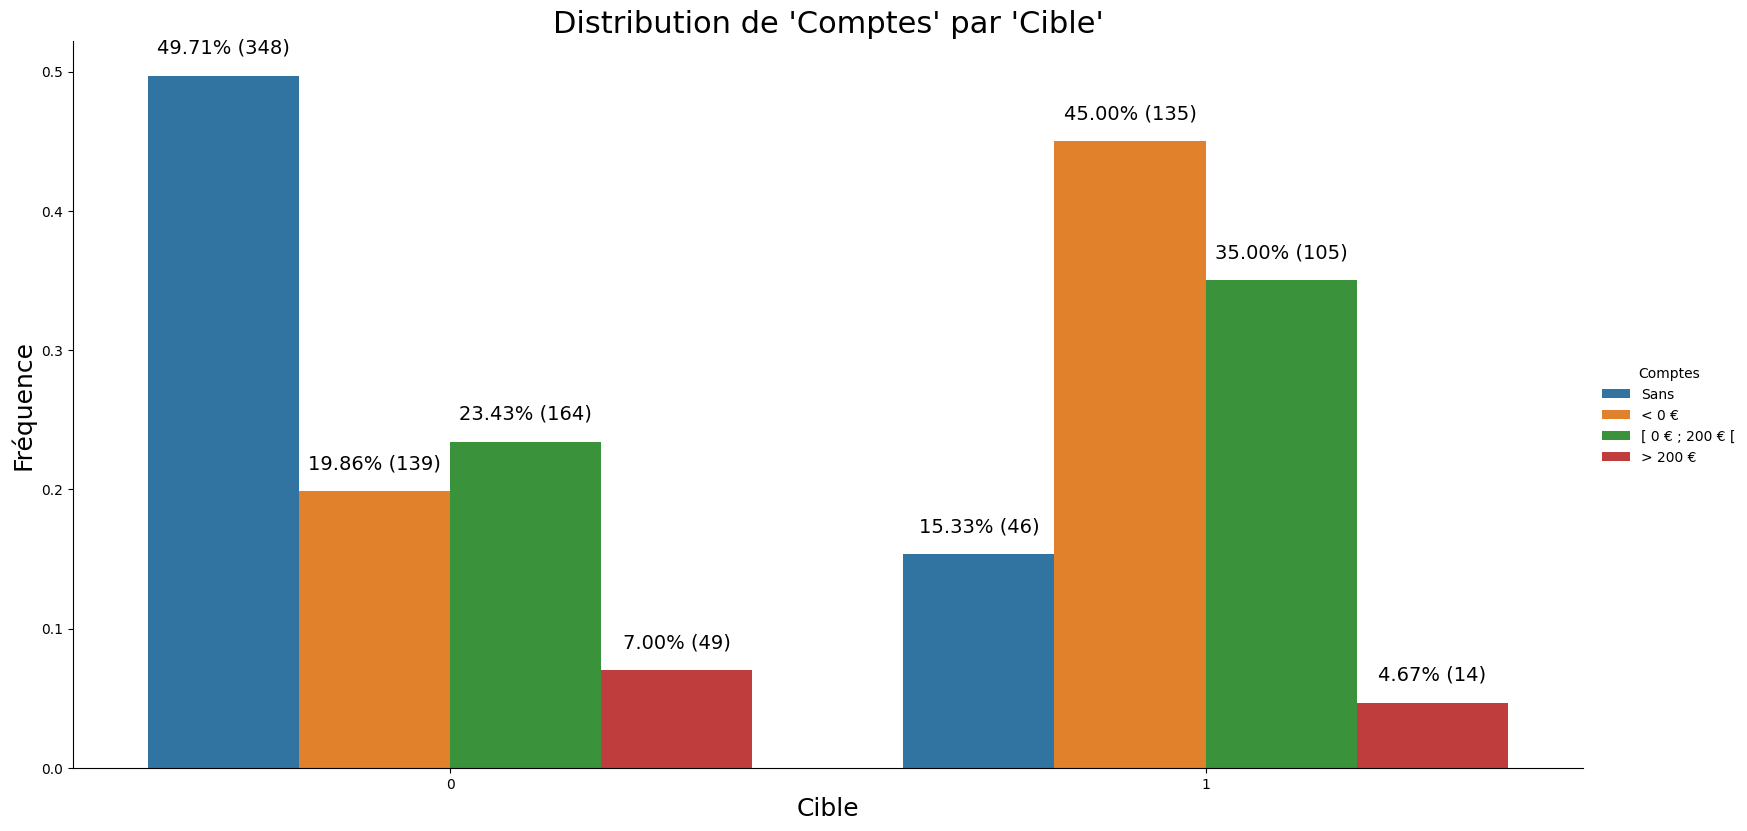

In [74]:
distrib_for_cat_by_target('Comptes',df,target)

<div class="alert alert-block alert-warning">
<b> Question 8:</b> Continuez sur les autres variables catégorielles. Vous pouvez passer par une boucle for pour itérer sur chaque variable
</div>

### 2.5 Représentations graphiques des continues par rapport à la cible

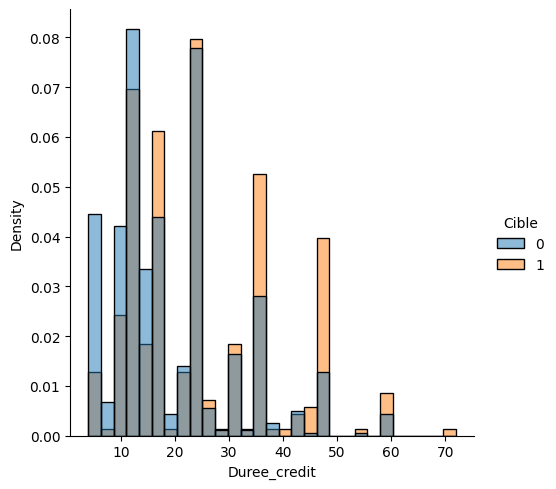

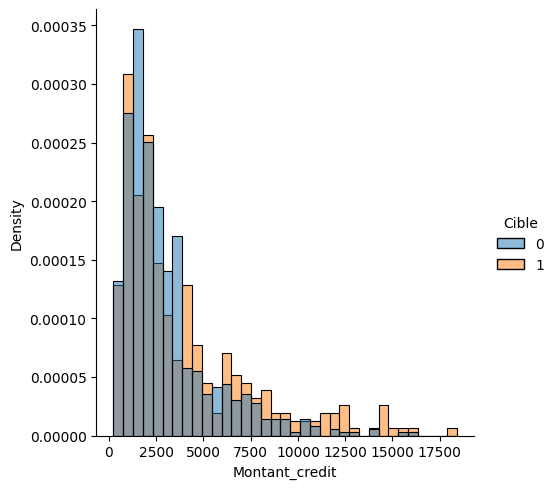

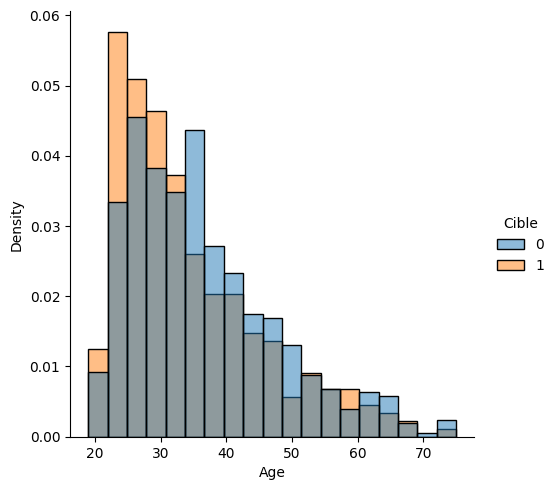

In [87]:
# Analyse pour les variables numériques 
for field in list_var_num:
    sns.displot(df, x=field, hue=target,stat="density",common_norm=False)

ℹ️ En utilisant la fonction <code>distrib_for_num_by_target</code>

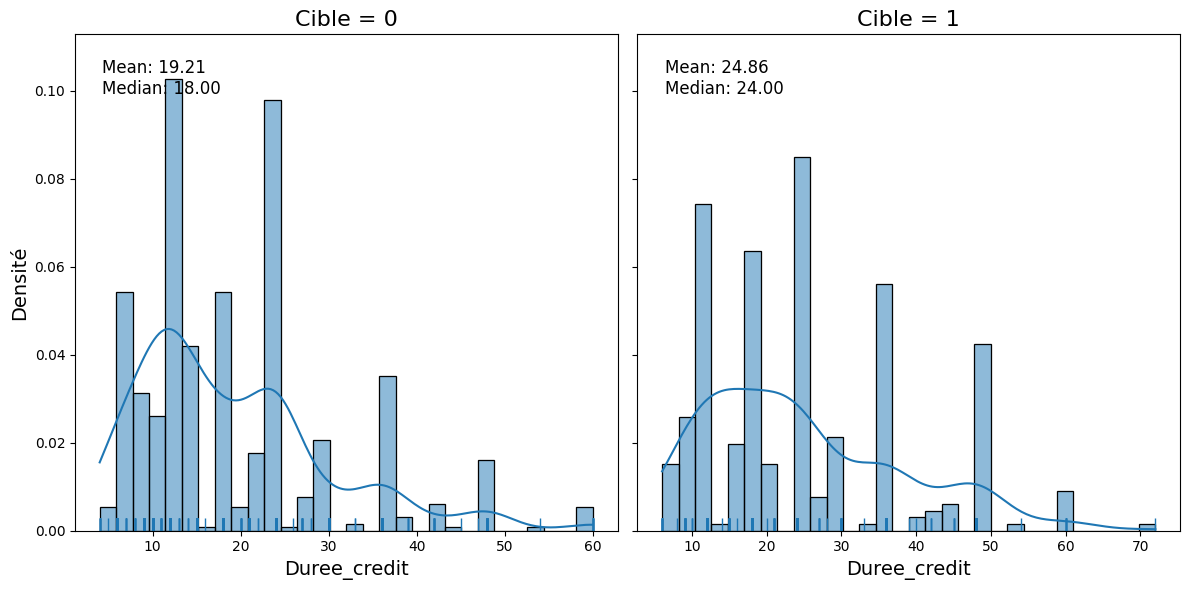

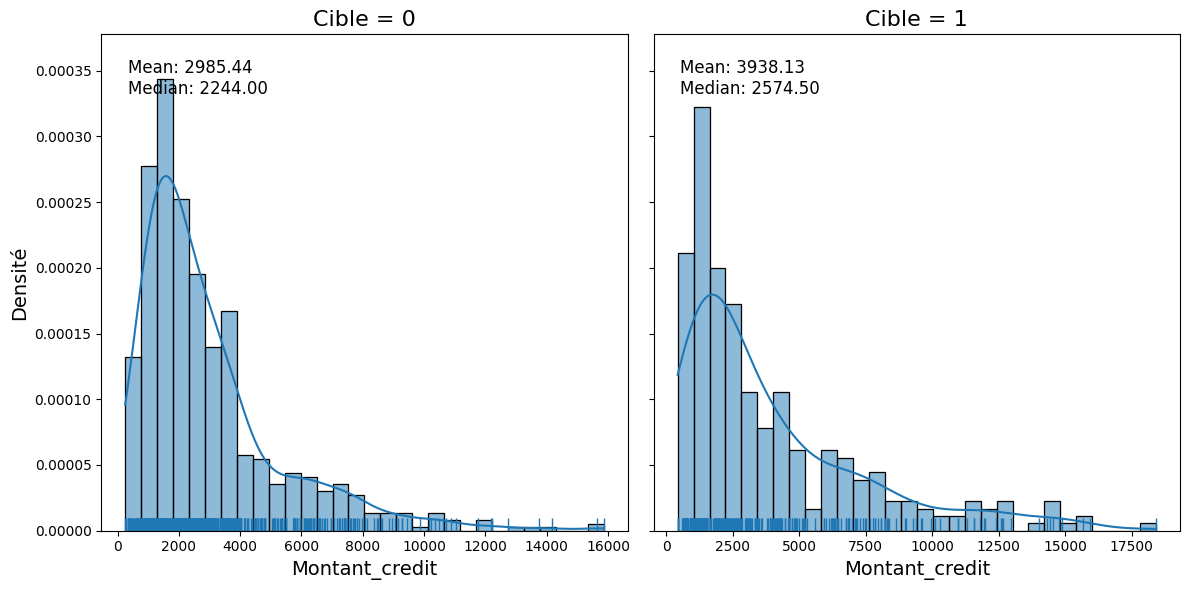

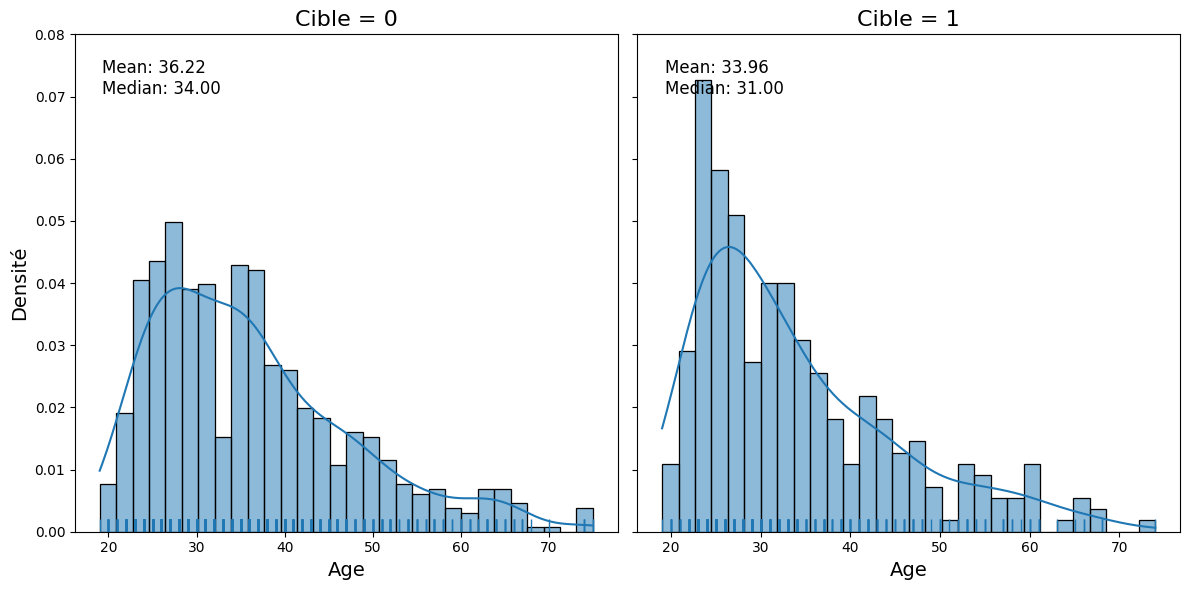

In [88]:
for field in list_var_num:
    distrib_for_cont_by_target(field,df,target)

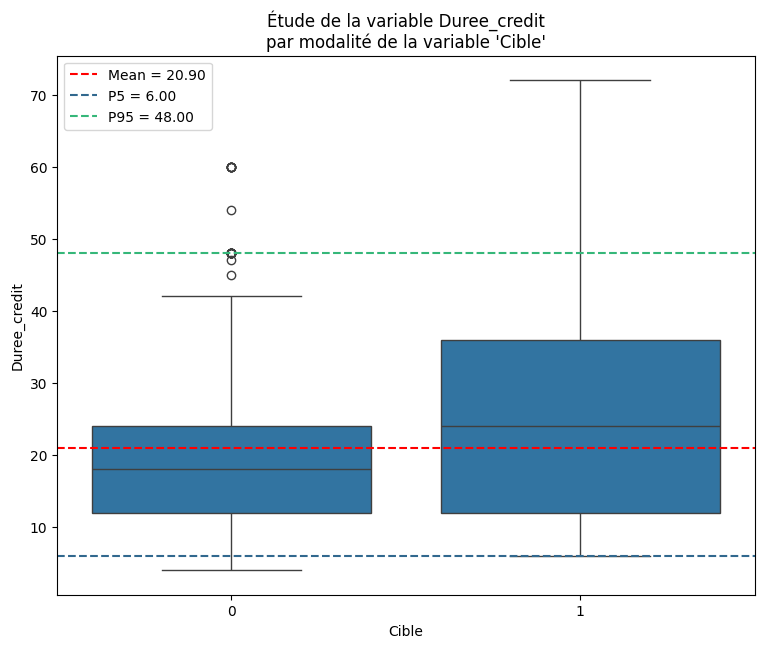

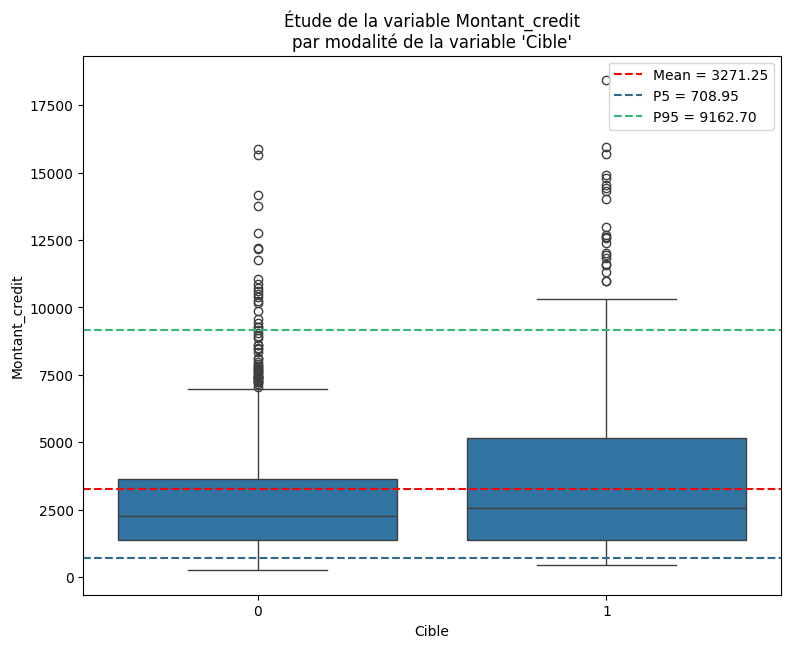

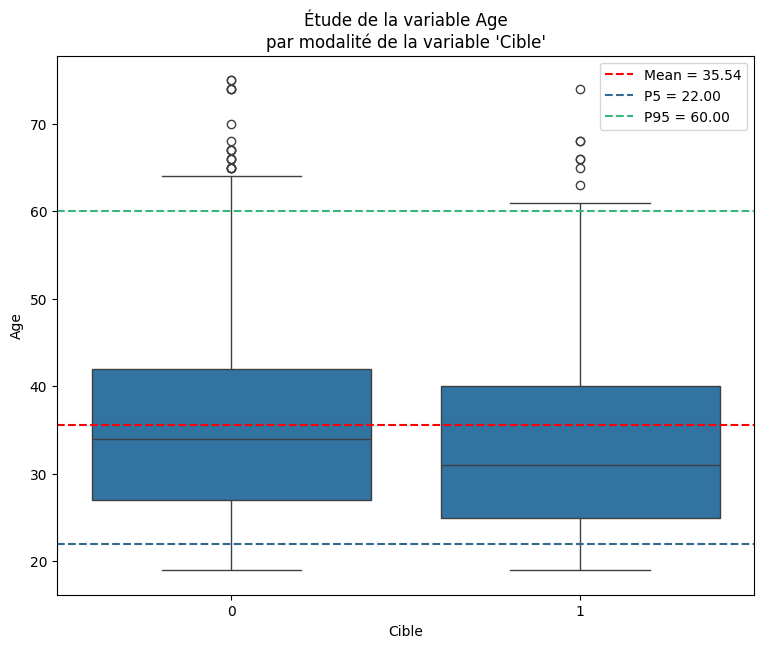

In [89]:
for field in list_var_num:
    boxplot_by_target(field,df,target,quantiles=[5,95])

<div class="alert alert-block alert-warning">
<b> Question 9:</b> Quelle remarque pouvez-vous faire à partir de l'étude des distributions ? 
</div>

### 2.6 Représentations graphiques avancées 

<b>Utilisez la fonction <code>plot_generic</code></b>

<div class="alert alert-block alert-info">
<b>📝Note :</b> La fonction <code>plot_generic</code> s'adapte selon le type de champ à étudier. Ainsi, vous pouvez utiliser aussi bien des catégorielles que des numériques.
</div>

Analyse des taux de défaut en fonction de la variable Age


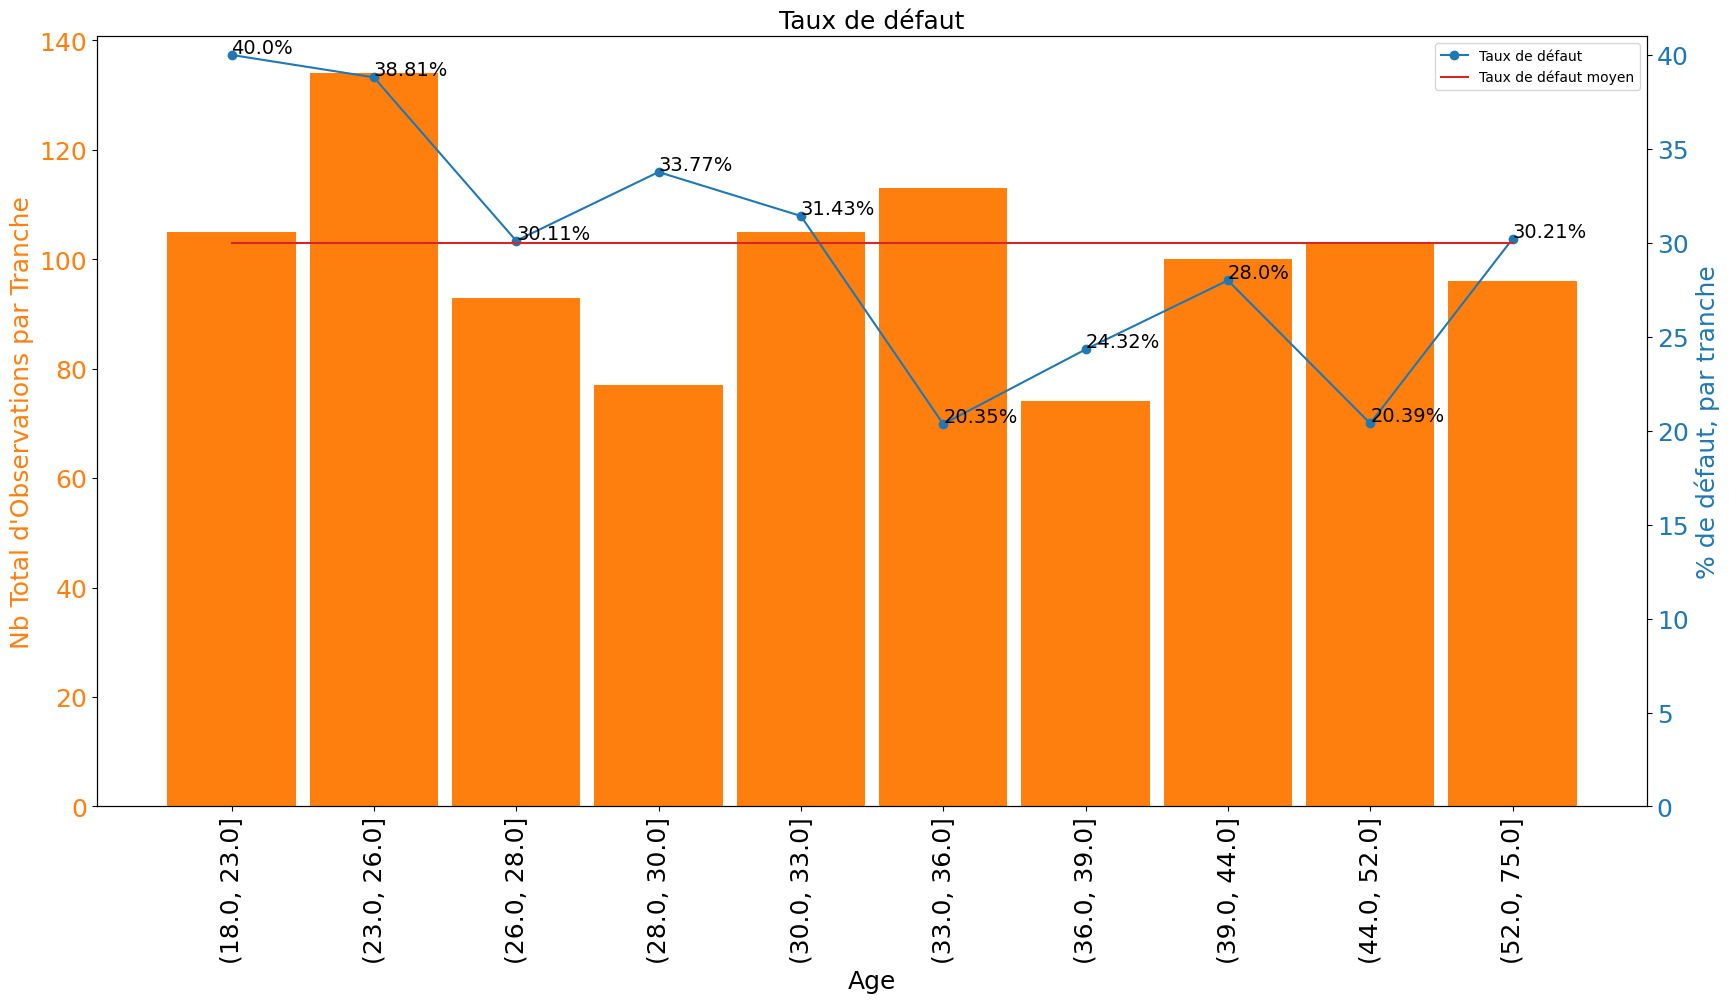

In [90]:
plot_generic(df,'Age',target, bins=10, force_binning=True)

<div class="alert alert-block alert-warning">
<b> Question 10:</b> Construisez le graphique pour d'autres variables
</div>

## 3. Etude du lien entre variables explicatives et variable cible

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> La <b>régression logistique</b> est très sensible à l'existence de multicolinéarités. 
Ainsi, il est préférable de prendre en compte les liens pouvant exister entre les variables afin de choisir plus efficacement celles que nous allons utiliser dans nos modèles de type régression logistique. 
</div>

#### Inutile si j'utilise un `modèle à base d'arbres` ?
1) Pour l'optimisation du modèle : pas nécessaire (voire dégrade le modèle car on retire de l'information)<br>
2) Dans le monde professionnel, très utile :
- permet d'avoir un premier a priori sur les facteurs pouvant expliquer la cible (et c'est plus rapide à lancer qu'un modèle)
- permet d'identifier des variables trop "magiques" càd qui expliquent trop bien la cible. Il est possible qu'il s'agissait 
d'un champ construit selon la cible (ex: numéro de contentieux renseigné --> défaut)
- permet de supprimer les variables sans lien avec la cible ce qui permet d'optimiser les temps de calculs (à l'entrainement
mais surtout en production quand le score sera utilisé)

### 3.1. Lien entre les `variables explicatives catégorielles`

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> On peut voir le V de Cramer comme la généralisation d'un test d'indépendance du Chi2
</div>

In [92]:
# Liste des variables catégorielles (pour rappel)
print(f'Liste des variables catégorielles : \n{list_var_cat}')

Liste des variables catégorielles : 
['Objet_credit', 'Historique_credit', 'Epargne', 'Anciennete_emploi', 'Situation_familiale', 'Anciennete_domicile', 'Nb_credits', 'Biens', 'Type_emploi', 'Comptes', 'Taux_effort', 'Autres_credits', 'Statut_domicile', 'Garanties', 'Telephone', 'Nb_pers_charge', 'Etranger']


<div class="alert alert-block alert-warning">
<b> Question 11:</b> en utilisant la fonction <code>cramers_v_between_all</code>, construisez un dataframe (que vous nommerez <code>df_vcramers</code>) contenant l'étude du lien (V de Cramer) entre les variables explicatives catégorielles.
</div>

<div class="alert alert-block alert-warning">
<b> Question 12:</b> Affichez le top10 des variables les plus liées entre elles. Qu'en déduisez-vous ?
</div>

<div class="alert alert-block alert-warning">
<b> Question 13:</b> Créez un dataframe contenant les couples dont le V de Cramer (absolu) est >0.40. Nommez ce dataframe <code>df_var_cat_liees</code>
</div>

### 3.2. Lien entre les `variables catégorielles` et la `variable cible`

<div class="alert alert-block alert-warning">
<b> Question 14:</b> En utilisant la fonction <code>cramers_v_with_target</code>, construisez un dataframe (que vous nommerez <code>df_vcramers_target</code>) contenant l'étude du lien (V de Cramer) entre les variables explicatives catégorielles
et la variable cible.
</div>

<div class="alert alert-block alert-warning">
<b> Question 15:</b> Quelles remarques pouvons-nous faire ?
</div>

<div class="alert alert-block alert-warning">
<b> Question 16:</b> En utilisant les sorties de <code>df_vcramers_target</code> et <code>df_var_cat_liees</code>, que pouvons-nous faire ? 
</div>

<div class="alert alert-block alert-warning">
<b> Question 17:</b> Créez la liste <code>list_var_cat_to_drop</code> contenant l'ensemble des variables catégorielles à supprimer
</div>

### 3.3 Etude du lien entre les variables explicatives continues 

<div class="alert alert-block alert-warning">
<b> Question 18:</b> Calculez la corrélation linéaire (Pearson) entre les variables continues 
</div>

<div class="alert alert-block alert-warning">
<b> Question 19:</b> Utilisez la fonction <code>graph_correlations</code> pour représenter graphiquement la matrice de corrélations
</div>

<div class="alert alert-block alert-warning">
<b> Question 20:</b> Utilisez la fonction <code>extract_corr_pairs</code> pour stocker dans un dataframe les corrélations linéaires
</div>

<div class="alert alert-block alert-warning">
<b> Question 21:</b> Affichez les lignes où la corrélation absolue est >=0.5 entre le couple de variables. Stockez les dans un dataframe nommé <code>high_corr_df</code>
</div>

### 3.4 Lien entre les variables explicatives continues et la variable cible

Application du Welch’s t-test

<div class="alert alert-block alert-info">
<b>🔔 Rappel :</b> Le Welch’s t-test est un test de Student où on relâche l'hypothèse d'équivariance entre les 2 populations.<br>
H0 : Les distributions de x|y=1 et x|y=0 sont les mêmes (avec x: variable explicative continue, y:variable cible bimodale)
</div>

In [107]:
for field in list_var_num:
    a=list(df[df[target]==0][field])
    b=list(df[df[target]==1][field])
    st_test, st_p = st.ttest_ind(a, b, axis=0, equal_var=False, nan_policy='omit')
    print(field + ": p-value test Student = " + str(st_p))

Duree_credit: p-value test Student = 2.404080859858094e-10
Montant_credit: p-value test Student = 2.4771030604498743e-05
Age: p-value test Student = 0.0037781754383747943


<div class="alert alert-block alert-warning">
<b> Question 22:</b> Qu'en déduisez-vous (à un seuil alpha=0.05)?
</div>